In [1]:
import sys
sys.path.append('../src')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
from gait.utils import get_overlap_data_all_sessions,  split_test_train_by_subjects, get_overlap_data_all_sessions
from gait.training import train_cnn_model_simple
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions

In [2]:
OVERLAP_PERCENT = 90
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan',
                    'MMuX9YIh4NTbLZLM',
                    'NKdnm6cN3KKAx7R4',
                    'PE8D53oX060qLbdX',
                    'xYdtS1F8tDyjEIgN',
                    'EUbKPOSQgjccjtvi',
                    'PE8D53oX060qLbdX',
                    'ddAeJA42PXvwthbW',
                    'LLZjAPTyj7muHsEf',
                    'cbOZWnI7s1y8oLD4',
                    'ddAeJA42PXvwthbW',
                    '1ZstYhEKzKKfGnMW',
                    'LLZjAPTyj7muHsEf',
                    'bQsRwKxgJiXTzo6P',
                    'sUZBISq61Y7I5tqQ',
                    '19AoxD1bgrDckd2p',
                    'wtyNo4LYaWXrkzA7',
                    ]



In [3]:
X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
# REMOVE UNWANTED SUBJECTS
indexes = np.where(subjects == exclude_subjects)
X = np.delete(X, indexes[0], axis=0)
y = np.delete(y, indexes[0], axis=0)
subjects = np.delete(subjects, indexes[0], axis=0)
# END REMOVE UNWANTED SUBJECTS

X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
    X, y, subjects, train_percent=0.8)


In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(126110, 128, 9)
(126110, 5)
(21726, 128, 9)
(21726, 5)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

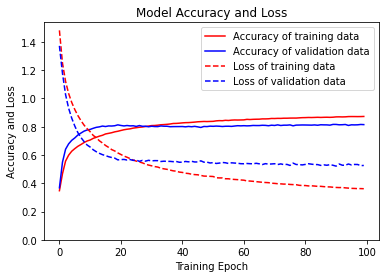

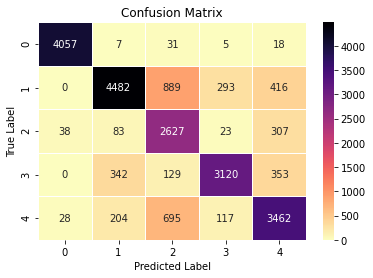

In [5]:
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    model, history = train_cnn_model_simple(
        X_train, y_train, X_test, overlap_percent=OVERLAP_PERCENT, batch_size=128, epochs=100)

    save_history(history, OVERLAP_PERCENT)
    evaluation_history = model.evaluate(
        X_test, y_test, batch_size=256, verbose=1)
    save_test_history(evaluation_history, OVERLAP_PERCENT)
    save_accuracy_loss_figure(history, OVERLAP_PERCENT)
    validations, predictions = compute_validations_predictions(
        model, X_test, y_test)
    save_confusion_matrix_figure(
        validations, predictions, OVERLAP_PERCENT, sns)


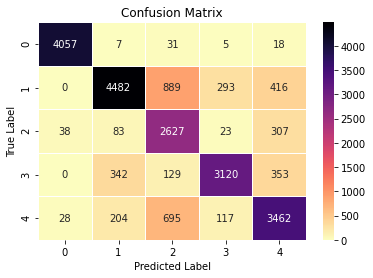

In [9]:
validations, predictions = compute_validations_predictions(
        model, X_test, y_test)
save_confusion_matrix_figure(
        validations, predictions, OVERLAP_PERCENT, sns)

In [10]:
model.save('6-channel-data-model-cnn.tflite')

INFO:tensorflow:Assets written to: 6-channel-data-model-cnn.tflite/assets


In [ ]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1).astype(np.float32)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

tflite_float_model_quant = converter.convert()
open('float-quantized-model.tflite', 'wb').write(tflite_float_model_quant)

In [11]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1).astype(np.float32)

def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train_reshape).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
open('int-quantized-model.tflite', 'wb').write(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpza0naxqx/assets


/home/sanjeev/.local/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


23472

In [12]:
interpreter = tf.lite.Interpreter(model_path=str('int-quantized-model.tflite'))
interpreter.allocate_tensors()


In [22]:
print(X_train_reshape.shape)
X_tensor = np.array([X_train_reshape[9000]]).astype(np.uint8)
print(X_tensor.shape)

(126110, 128, 9, 1)
(1, 128, 9, 1)


In [23]:
input_details = interpreter.get_input_details();
print('\n',input_details, '\n');
interpreter.set_tensor(input_details[0]['index'], X_tensor)


 [{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   9,   1], dtype=int32), 'shape_signature': array([ -1, 128,   9,   1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.014720242470502853, 176), 'quantization_parameters': {'scales': array([0.01472024], dtype=float32), 'zero_points': array([176], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] 



In [24]:
interpreter.invoke()
predictions = interpreter.get_tensor(interpreter.get_output_details()[0]["index"])
print(predictions)

[[207  15  26   3   4]]


In [25]:
def invoke_print_result(X_tensor):
    interpreter = tf.lite.Interpreter(model_path=str('int-quantized-model.tflite'))
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], X_tensor)
    interpreter.set_tensor(input_details[0]['index'], X_tensor)
    interpreter.invoke()
    predictions = interpreter.get_tensor(interpreter.get_output_details()[0]["index"])
    print(predictions)

In [41]:
idx = 7020
X_t = np.array([X_train_reshape[idx]]).astype(np.uint8)
y_t = y_train[idx]

invoke_print_result(X_t)
print(y_t)

[[219  13  19   2   4]]
[0. 0. 0. 0. 1.]


In [65]:
def predict_tflite(tflite_model, x_test):
    # Prepare the test data
    x_test_ = x_test.copy()
    n, win_len, channel, _ = x_test.shape
    # x_test_ = x_test_.reshape((x_test.size, 1))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    print('input details index', input_details)

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    # Invoke the interpreter
    y_pred = np.empty((n, 5), dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        # print(interpreter.get_tensor(output_details["index"])[0])
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred


def evaluate_tflite(tflite_model, x_test, y_true):
    global model
    y_pred = predict_tflite(tflite_model, x_test)
    loss_function = tf.keras.losses.get(model.loss)
    loss = loss_function(y_true, y_pred).numpy()
    return loss


In [66]:
# Calculate predictions
y_test_pred_tf = model.predict(X_test)
# y_test_pred_no_quant_tflite = predict_tflite(model, X_test)
X_t = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1).astype(np.uint8)

y_test_pred_tflite = predict_tflite(tflite_model_quant, X_t)

input details index {'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   9,   1], dtype=int32), 'shape_signature': array([ -1, 128,   9,   1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.014720242470502853, 176), 'quantization_parameters': {'scales': array([0.01472024], dtype=float32), 'zero_points': array([176], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [69]:
print(y_test_pred_tflite.shape)
print(y_test_pred_tf.shape)

(21726, 5)
(21726, 5)


In [70]:
y_pred_test = model.predict(X_test)


In [71]:
max_y_pred_tf = np.argmax(y_test_pred_tf, axis=1)
max_y_pred_tflite = np.argmax(y_test_pred_tflite, axis=1)
max_y_pred_test_no_quant = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)


In [72]:
from sklearn import metrics

In [83]:
def plot_confusion_mat(validations, predictions, title):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='magma_r',
                linecolor='white',
                linewidths=1,
                annot=True,
                fmt='d')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

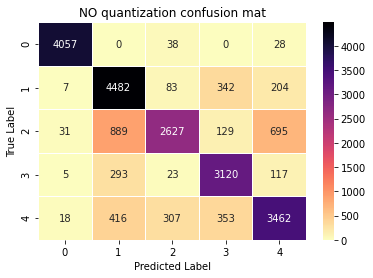

In [84]:
plot_confusion_mat(max_y_test, max_y_pred_test_no_quant, 'NO quantization confusion mat')

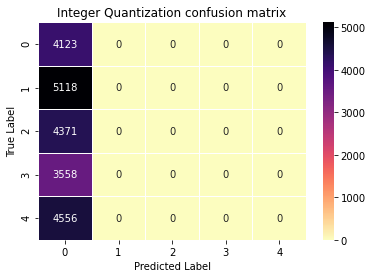

In [85]:
plot_confusion_mat(max_y_test, max_y_pred_tflite, 'Integer Quantization confusion matrix')


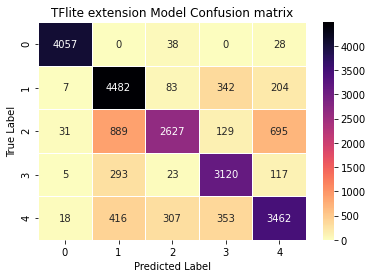

In [86]:
plot_confusion_mat(max_y_test, max_y_pred_tf, 'TFlite extension Model Confusion matrix')
